<center><h1>Deep Q-Learning (DQN)</h1></center>

DQN uses a neural network to approximate the Q-values. The loss function such as the MSE loss can be:
$$ L = \left(Q(s, a;\theta) - (r + \gamma \max_{a'} Q(s', a';\theta')) \right) ^ 2 \tag{3}$$

The update rule depends on the values produced by the network itself, making convergence diffucult. To address this, the DQN algorithm introduces the use of a replay buffer and target networks. The replay buffer stores past interactions as a list of tuples, which can be sampled to update the value and policy networks. This allows the network to learn from individual tuples multiple times and reduces dependence on the current experience. The target networks are time-delayed copies of the policy and Q-networks, and their parameters are updated according to the following equations:

$$ \theta_Q' \leftarrow \tau \theta_Q + (1 - \tau) \theta_Q' \tag{4}$$
$$ \theta_\mu' \leftarrow \tau \theta_\mu + (1 - \tau) \theta_\mu' \tag{5}$$

where $\theta_\mu'$ and $\theta_Q'$ denote the parameters of the policy and Q-networks, respectively.

![](./images/dqn.webp)

# 1. Prelims 

In [1]:
import random
from collections import deque

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn

GAMMA = 0.99
MINI_BATCH_SIZE = 32
BUFFER_SIZE = 50000
MIN_REPLAY_SIZE = 1000
EPSILON_START = 1.0
EPSILON_END = 0.02
EPSILON_DECAY = 10000
TARGET_UPDATE_FREQUENCY = 1000

# 2. Model

In [2]:
from model.dqn import DQN

# 3. Training

In [3]:
def run_step(
    env: gym.Env,
    observation: np.ndarray,
    online_net: DQN,
    target_net: DQN,
    epsilon_gen,
    optimizer,
    replay_buffer: deque,
    reward_buffer: deque,
    episode_reward: float,
    criterion,
    batch_size: int,
):
    epsilon = next(epsilon_gen)
    random_sample = random.random()
    action = (
        env.action_space.sample()
        if random_sample <= epsilon
        else online_net.act(observation)
    )

    next_observation, reward, terminated, truncated, info = env.step(action)
    memory = (observation, action, reward, terminated, next_observation)
    replay_buffer.append(memory)
    observation = next_observation

    episode_reward += reward

    if terminated:
        observation, info = env.reset()
        reward_buffer.append(episode_reward)
        episode_reward = 0.0

    # Start Gradient Step
    memories = random.sample(replay_buffer, batch_size)
    all_obs_tensor = torch.as_tensor(np.asarray([memo_i[0] for memo_i in memories]), dtype=torch.float32)  # [batch, 4]
    all_a_tensor = torch.as_tensor(np.asarray([memo_i[1] for memo_i in memories]), dtype=torch.int64).unsqueeze(-1)  # [batch, 1]
    all_r_tensor = torch.as_tensor(np.asarray([memo_i[2] for memo_i in memories]), dtype=torch.float32).unsqueeze(-1)  # [batch, 1]
    all_done_tensor = torch.as_tensor(np.asarray([memo_i[3] for memo_i in memories]), dtype=torch.float32).unsqueeze(-1)  # [batch, 1]
    all_next_obs_tensor = torch.as_tensor(np.asarray([memo_i[4] for memo_i in memories]), dtype=torch.float32)  # [batch, 4]

    # Compute Targets
    target_q_values = target_net(all_next_obs_tensor)  # [batch, 2]
    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]  # [batch, 1]
    targets = all_r_tensor + GAMMA * (1 - all_done_tensor) * max_target_q_values

    # Compute Loss
    q_values = online_net(all_obs_tensor)
    a_q_values = torch.gather(input=q_values, dim=1, index=all_a_tensor)
    loss = criterion(a_q_values, targets)

    # Gradient Descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return observation, episode_reward

In [4]:
def create_replay_buffer(replay_buffer, env: gym.Env, replay: int):
    observation, info = env.reset()
    for _ in range(replay):
        action = env.action_space.sample()
        observation_, reward, terminated, truncated, info = env.step(action)
        memory = (observation, action, reward, terminated, observation_)
        replay_buffer.append(memory)
        observation = observation_

        if terminated:
            observation, info = env.reset()

In [5]:
def epsilon_generator(start, end, decay):
    step = 0
    while True:
        epsilon = np.interp(step, [0, decay], [start, end])
        yield epsilon
        step += 1


Step: 0
Avg reward: 0.0

Step: 1000
Avg reward: 21.5

Total episodes:  83


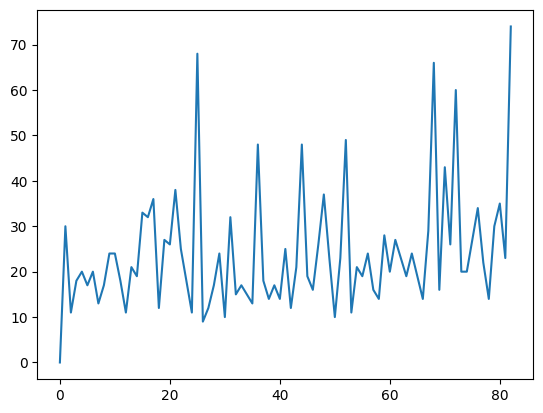

In [7]:
env = gym.make("CartPole-v1")
replay_buffer = deque(maxlen=BUFFER_SIZE)
reward_buffer = deque([0.0], maxlen=100)
episode_reward = 0.0

in_features = int(np.prod(env.observation_space.shape))
num_actions = env.action_space.n

online_net = DQN(in_features, num_actions)
target_net = DQN(in_features, num_actions)
optimizer = torch.optim.Adam(online_net.parameters(), lr=5e-4)
criterion = nn.functional.smooth_l1_loss

create_replay_buffer(replay_buffer, env, MIN_REPLAY_SIZE)
epsilon_gen = epsilon_generator(EPSILON_START, EPSILON_END, EPSILON_DECAY)
observation, info = env.reset()

for step in range(2000):
    online_net.train()
    observation, episode_reward = run_step(
        env=env,
        observation=observation,
        online_net=online_net,
        target_net=target_net,
        epsilon_gen=epsilon_gen,
        optimizer=optimizer,
        replay_buffer=replay_buffer,
        reward_buffer=reward_buffer,
        episode_reward=episode_reward,
        criterion=criterion,
        batch_size=MINI_BATCH_SIZE,
    )

    # # After solved, watch it play
    # if len(reward_buffer) >= 100:
    #     if np.mean(reward_buffer) >= 30000:
    #         while True:
    #             action = online_net.act(observation)
    #             observation, reward, terminated, truncated, info = env.step(action)
    #             env.render()

    #             if terminated:
    #                 env.reset()

    # Update target network
    if step % TARGET_UPDATE_FREQUENCY == 0:
        target_net.load_state_dict(online_net.state_dict())

    # Print the training progress
    if step % 1000 == 0:
        print()
        print("Step: {}".format(step))
        print("Avg reward: {}".format(np.mean(reward_buffer)))
        torch.save(online_net.state_dict(), "./checkpoint/dqn_model_{}.pth".format(step))

print("\nTotal episodes: ", len(reward_buffer))
import matplotlib.pyplot as plt
plt.plot(reward_buffer)
plt.show()

env.close()